In [1]:
import pandas as pd
from pyhanlp import *
import jieba
import numpy as np

df = pd.read_excel('Lawsnote法律黑客松＿判決摘要.xlsx',sheet_name='慰撫金')

# 濾除雜質
for idx, row in df.iterrows():
    for col in df.columns:
        if type(df.iloc[idx][col]) == str:
            value = df.iloc[idx][col]
            value = value.strip()
            value = value.replace('未滿','').replace('不明','').replace('未主張','')
            value = value.replace('目前沒有工作','').replace('目前在監服刑','').replace('在監執行','')
            value = value.replace('無','').replace('目前在監服刑','').replace('在監執行','')
            df.iloc[idx][col] = value 
            
        if col == '年齡':
            if ('nan' in value) or (value == ''): df.iloc[idx][col] = 0
                    
                
                                        
# 留下必要row           
col = [c for c in df.columns if c not in ['法院']]
df = df.drop([0,1])
df = df.reset_index(drop=True)
df = df.dropna(subset=['最後判賠金額'])
df = df[df["犯罪類型"] != 'X']

In [2]:
df.head()

,法院,主文,犯罪類型,職業,產業,階級,學歷,年齡,等級,數額,財產總額,財產種類,原告主張,原告年紀,被告主張,有利原告,有利被告,原告要求金額,最後判賠金額
0,臺灣新北地方法院107年訴字第1661號民事判決,臺灣新北地方法院民事判決107年度訴字第1661號原告0000-000000（真實姓名年籍均...,強制性交,"餐飲及溫泉會館,老闆",住宿及餐飲業,老闆,NaN,NaN,經濟狀況良好,1000000,NaN,NaN,服用藥物昏沈不能抗拒,52,,趁原告服用安眠藥法抗拒\n事後悔意從未道歉\n指稱原告設局引誘被告,NaN,800000,500000
2,臺灣高等法院107年上易字第56號民事判決,臺灣高等法院民事判決107年度上易字第56號上訴人王凱民訴訟代理人王俊傑律師被上訴人A女(0...,強制性交未遂,待業,NaN,NaN,大學肄業,NaN,NaN,52540,NaN,NaN,因酒醉不知不能抗拒,NaN,當日因飲酒過量精神恍惚\n證人之證詞互有矛盾\nDNA未為23種型別比對\n請求之賠償金額過高,被告利用原告酒醉不知不能抗拒,NaN,1300000,900000
3,臺灣新北地方法院107年訴字第727號民事判決,臺灣新北地方法院民事判決107年度訴字第727號原告林明子訴訟代理人蔣宗翰律師張君維被告徐松...,性騷擾,待業,NaN,NaN,國小畢業,NaN,NaN,36000,NaN,"投資:1,不動產:1",被告不滿原告以徒手拍打其臀部，而徒手反推原告\n原告當場倒地，造成原告背部外傷及骨折,NaN,正當防衛，傷害故意\n被告才是受害人,NaN,NaN,700000,50000
4,臺灣臺北地方法院106年醫字第16號民事判決,臺灣臺北地方法院民事判決106年度醫字第16號原告A女（真實姓名、住居所詳卷）訴訟代理人周珊...,性騷擾,醫師,醫療保健業,員工,NaN,NaN,NaN,1914876,NaN,NaN,被告趁原告尋求醫療協助之際，要求發生性行為\n醫療行為不當，致原告腿部神經病變,NaN,術前已盡評估之事\n原告為護士，於術前應已了解風險,趁病人不適且法逃脫醫師治療之依賴\n違反道德,NaN,300000,250000
5,臺灣高等法院臺中分院107年訴易字第78號民事判決,臺灣高等法院臺中分院民事判決107年度訴易字第78號原告A女（代號0000-000000）（...,強制性交,待業,NaN,NaN,專科肄業,NaN,輕度精神障礙\n存款\n領有重大傷病證明卡,0,NaN,NaN,被告明知其為低智商而強制性交,NaN,二人互有情愫\n並未暴力脅迫原告\n經濟能力不佳，不應請求高額求償金,被告明知其為低智商而強制性交,NaN,1000000,400000


In [3]:
def education(text):
    if text!= None and type(text) == str:
        try:
            text = text.replace('\n','')
            seg_list = jieba.cut(text)
            seg_list = [s for s in seg_list]

            seg_list_1 = "".join(seg_list[:-1])
            seg_list_2 = seg_list[-1]

            if 'nan' in seg_list_2: return [0,0]
            if seg_list_1 == '': return [seg_list_2]
            return [seg_list_1,seg_list_2]
        except Exception as e:
            return [0,0]
    else: return [0,0]

def study(v):
    level = 0
    if type(v[0]) == str:
        text = v[0]
        if text in ['國小']: level = 0
        elif text in ['初中','國中','國 中']: level =  1
        elif text in ['高中','高職','高工','家商']: level =  2
        elif text in ['大學','空中大學','二專','專科','大專','技術學院']: level =  3
        elif text in ['研究','碩士']: level =  4
        elif text in ['博士']: level =  5
        if len(v)>1:
            if '肄業' in v[1]: return (level-0.5)
            else: return level

    
def extract_age(text):
    if type(text) == str:
        seg_list = jieba.cut(text)
        for s in seg_list:
            if s.isdigit(): return int(s)
    else:
        return text   
    

    
    

# 年齡處理
df['年齡'] = df['年齡'].fillna(0)
df['年齡'] = df['年齡'].apply(extract_age)
age_count = [v for v in df['年齡'] if v > 0]
df['年齡'] = df['年齡'].apply(lambda x : x if x>0 else np.mean(age_count)) # 年齡填充


# 學歷處理  
df['學歷'] = df['學歷'].apply(education)
level_dict = [v[0] for v in df['學歷'] if type(v[0]) == str]
level_dict = ['國小','初中','國中','國 中','高中','高職','高工','大學','空中大學','二專','碩士']           
df['學歷'] = df['學歷'].apply(study)  
study_count = [v for v in df['學歷'] if v > 0]
df['學歷'] = df['學歷'].apply(lambda x : x if x>0 else np.mean(study_count)) # 學歷填充

# 原告年紀處理 
df['原告年紀'] = df['原告年紀'].fillna(0)
hurt_age_count = [int(v) for v in df['原告年紀'] if int(v) > 0]
df['原告年紀'] = df['原告年紀'].apply(lambda x : x if x>0 else np.max(hurt_age_count)) # 原告年紀

# df
df[['職業','產業','階級','學歷','年齡']].tail()

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\jack\AppData\Local\Temp\jieba.cache
Loading model cost 0.897 seconds.
Prefix dict has been built succesfully.


,職業,產業,階級,學歷,年齡
221,",公車司機",公共汽車客運業,員工,1.954955,36.272727
222,",法師",其他個人服務業,老闆,2.000000,36.272727
223,待業,NaN,NaN,1.954955,18.000000
224,",戲劇製作人","創作及藝術表演業, 藝文服務業",主管,1.954955,36.272727
225,待業,NaN,NaN,1.954955,36.272727


In [4]:
# 數額填充
import operator
employee = pd.read_excel('Lawsnote法律黑客松＿判決摘要.xlsx',sheet_name='薪情平臺匯出資料') # 薪情平臺匯出資料

employee.head()  
employee_money ={} # 薪資排行榜
employee_mapping={} 
for idx, row in employee.iterrows():
    employee_money[list(row)[0]] = list(row)[2]    
    if type(list(row)[1]) == str:
        employee_mapping[list(row)[0]] = list(row)[1].split(',')
    

employee_rank = sorted(employee_money.items(), key=operator.itemgetter(1),reverse=True)
employee_rank = [e[0] for e in employee_rank]          

def fill_money(row):
    if row['數額']: return row['數額']
    else:
        return employee_money[row['產業']]

    
    
# df['數額'] = df.apply(fill_money)
df['階級'] = df['階級'].fillna('待業')
df['產業'] = df['產業'].fillna('待業')
# df['財產種類'] = df['財產種類'].fillna('無財產')
df[['職業','產業','階級','學歷','年齡','數額']].head()

,職業,產業,階級,學歷,年齡,數額
0,"餐飲及溫泉會館,老闆",住宿及餐飲業,老闆,1.954955,36.272727,1000000
2,待業,待業,待業,2.500000,36.272727,52540
3,待業,待業,待業,1.954955,36.272727,36000
4,醫師,醫療保健業,員工,1.954955,36.272727,1914876
5,待業,待業,待業,2.500000,36.272727,0


In [5]:
# 刪除不必要的columns
df = df.drop(["法院", "主文", "職業", "產業", "等級", "財產總額"], axis=1)
# 所有\n化為，
df.replace('\n','，', inplace=True, regex=True)

# 刪除犯罪類型為nan的index
Nanlist = df[df["犯罪類型"].isnull().values==True].index.tolist()
df = df.drop(Nanlist)

df.reset_index(drop=True, inplace=True)
df.head()

,犯罪類型,階級,學歷,年齡,數額,財產種類,原告主張,原告年紀,被告主張,有利原告,有利被告,原告要求金額,最後判賠金額
0,強制性交,老闆,1.954955,36.272727,1000000,NaN,服用藥物昏沈不能抗拒,52,,趁原告服用安眠藥法抗拒，事後悔意從未道歉，指稱原告設局引誘被告,NaN,800000,500000
1,強制性交未遂,待業,2.500000,36.272727,52540,NaN,因酒醉不知不能抗拒,52,當日因飲酒過量精神恍惚，證人之證詞互有矛盾，DNA未為23種型別比對，請求之賠償金額過高,被告利用原告酒醉不知不能抗拒,NaN,1300000,900000
2,性騷擾,待業,1.954955,36.272727,36000,"投資:1,不動產:1",被告不滿原告以徒手拍打其臀部，而徒手反推原告，原告當場倒地，造成原告背部外傷及骨折,52,正當防衛，傷害故意，被告才是受害人,NaN,NaN,700000,50000
3,性騷擾,員工,1.954955,36.272727,1914876,NaN,被告趁原告尋求醫療協助之際，要求發生性行為，醫療行為不當，致原告腿部神經病變,52,術前已盡評估之事，原告為護士，於術前應已了解風險,趁病人不適且法逃脫醫師治療之依賴，違反道德,NaN,300000,250000
4,強制性交,待業,2.500000,36.272727,0,NaN,被告明知其為低智商而強制性交,52,二人互有情愫，並未暴力脅迫原告，經濟能力不佳，不應請求高額求償金,被告明知其為低智商而強制性交,NaN,1000000,400000


In [6]:
#犯罪類型 one hot encoding
crime_df = pd.get_dummies(df["犯罪類型"])
crime_df.head()

,乘機性交,強制性交,強制性交、猥褻,強制性交未遂,性騷擾,猥褻,與未成年人合意性交
0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0


In [7]:
#階級 one hot encoding
level_df = pd.get_dummies(df["階級"])
level_df.head()

,主管,員工,待業,老闆
0,0,0,0,1
1,0,0,1,0
2,0,0,1,0
3,0,1,0,0
4,0,0,1,0


In [8]:
# 財產種類 one hot encoding
t_investment = 0   # 投資
t_real_estate = 0  # 不動產
t_car = 0          # 汽車
t_house = 0        # 房屋
t_land = 0         # 土地
t_motorcycle = 0   # 機車

investment = []   # 投資
real_estate = []  # 不動產
car = []          # 汽車
house = []        # 房屋
land = []         # 土地
motorcycle = []   # 機車

for index in df["財產種類"]:
    if not pd.isnull(index):
        comma = index.split(",")
        for item in comma:
            temp = item.split(":")
            if temp[1] == "n":        # n設定為5
                temp[1] = 5
            
            if temp[0] == "投資":
                t_investment = temp[1]
            elif temp[0] == "不動產":
                t_real_estate = temp[1]
            elif temp[0] == "汽車":
                t_car = temp[1]
            elif temp[0] == "房屋":
                t_house = temp[1]
            elif temp[0] == "土地":
                t_land = temp[1]
            elif temp[0] == "機車":
                t_motorcycle = temp[1]
        investment.append(t_investment)
        real_estate.append(t_real_estate)
        car.append(t_car)
        house.append(t_house)
        land.append(t_land)
        motorcycle.append(t_motorcycle)
        
        t_investment = 0   # 投資
        t_real_estate = 0  # 不動產
        t_car = 0          # 汽車
        t_house = 0        # 房屋
        t_land = 0         # 土地
        t_motorcycle = 0   # 機車
    else:
        investment.append(0)
        real_estate.append(0)
        car.append(0)
        house.append(0)
        land.append(0)
        motorcycle.append(0)

c = {"投資":investment,
     "不動產":real_estate,
     "汽車":car,
     "房屋":house,
     "土地":land,
     "機車":motorcycle}
belongings = pd.DataFrame(c)
belongings.head()

,投資,不動產,汽車,房屋,土地,機車
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,1,1,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [9]:
# 刪除columns(犯罪類型、階級、財產種類、原告年紀)
df = df.drop(["犯罪類型", "階級", "財產種類", "原告年紀", "原告主張", "被告主張", "有利原告", "有利被告", "原告要求金額"], axis=1)
df.head()

,學歷,年齡,數額,最後判賠金額
0,1.954955,36.272727,1000000,500000
1,2.500000,36.272727,52540,900000
2,1.954955,36.272727,36000,50000
3,1.954955,36.272727,1914876,250000
4,2.500000,36.272727,0,400000


In [10]:
final_df = pd.concat([df,crime_df,level_df,belongings],axis=1)
final_df.head()

,學歷,年齡,數額,最後判賠金額,乘機性交,強制性交,強制性交、猥褻,強制性交未遂,性騷擾,猥褻,...,主管,員工,待業,老闆,投資,不動產,汽車,房屋,土地,機車
0,1.954955,36.272727,1000000,500000,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2.500000,36.272727,52540,900000,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1.954955,36.272727,36000,50000,0,0,0,0,1,0,...,0,0,1,0,1,1,0,0,0,0
3,1.954955,36.272727,1914876,250000,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,2.500000,36.272727,0,400000,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [11]:
final_df.columns

Index(['學歷', '年齡', '數額', '最後判賠金額', '乘機性交', '強制性交', '強制性交、猥褻', '強制性交未遂', '性騷擾',
       '猥褻', '與未成年人合意性交', '主管', '員工', '待業', '老闆', '投資', '不動產', '汽車', '房屋',
       '土地', '機車'],
      dtype='object')

In [12]:
final_df.columns = ['最後判賠金額', '學歷', '年齡', '數額', '乘機性交', '強制性交', '強制性交、猥褻', '強制性交未遂', '性騷擾',
       '猥褻', '與未成年人合意性交', '主管', '員工', '待業', '老闆', '投資', '不動產', '汽車', '房屋',
       '土地', '機車']

In [13]:
final_df.head()

,最後判賠金額,學歷,年齡,數額,乘機性交,強制性交,強制性交、猥褻,強制性交未遂,性騷擾,猥褻,...,主管,員工,待業,老闆,投資,不動產,汽車,房屋,土地,機車
0,1.954955,36.272727,1000000,500000,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2.500000,36.272727,52540,900000,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1.954955,36.272727,36000,50000,0,0,0,0,1,0,...,0,0,1,0,1,1,0,0,0,0
3,1.954955,36.272727,1914876,250000,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,2.500000,36.272727,0,400000,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [14]:
# # 計算相關係數
# import scipy.stats as stats

# stats.pearsonr(df.學歷, df.最後判賠金額)

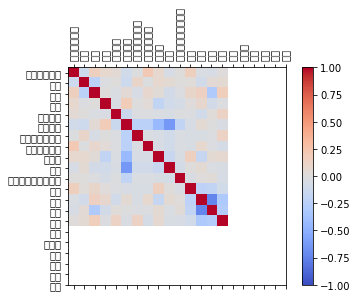

In [17]:
import matplotlib.pyplot as plt
corr = final_df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(final_df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(final_df.columns)
ax.set_yticklabels(final_df.columns)
plt.show()

In [18]:
final_df.corr()

,最後判賠金額,學歷,年齡,數額,乘機性交,強制性交,強制性交、猥褻,強制性交未遂,性騷擾,猥褻,與未成年人合意性交,主管,員工,待業,老闆
最後判賠金額,1.000000,-1.114638e-01,0.153168,0.073620,4.113365e-02,-0.081285,-0.014003,0.207788,0.071983,-0.049292,7.286571e-03,0.158374,-0.026176,-0.053043,0.011963
學歷,-0.111464,1.000000e+00,-0.229454,-0.022911,1.049766e-17,-0.115287,0.105553,-0.009324,0.073215,0.047292,1.491783e-17,0.020639,-0.080351,0.039908,0.051740
年齡,0.153168,-2.294545e-01,1.000000,0.002836,-2.705854e-02,0.042679,-0.054639,0.082849,0.029706,-0.074810,-1.641066e-02,0.097365,0.144798,-0.298809,0.171089
數額,0.073620,-2.291114e-02,0.002836,1.000000,-3.341245e-02,0.181447,-0.001121,0.037888,-0.181679,-0.078163,-5.569946e-02,0.008380,0.083508,-0.076170,-0.020088
乘機性交,0.041134,1.049766e-17,-0.027059,-0.033412,1.000000e+00,-0.131559,-0.016817,-0.016817,-0.030927,-0.046090,-1.366406e-02,-0.023054,-0.088271,0.021012,0.126553
強制性交,-0.081285,-1.152869e-01,0.042679,0.181447,-1.315587e-01,1.000000,-0.230089,-0.230089,-0.423152,-0.630614,-1.869531e-01,-0.047793,0.051393,-0.007260,-0.037087
強制性交、猥褻,-0.014003,1.055532e-01,-0.054639,-0.001121,-1.681682e-02,-0.230089,1.000000,-0.029412,-0.054090,-0.080610,-2.389775e-02,-0.040321,-0.039417,-0.021715,0.128000
強制性交未遂,0.207788,-9.324487e-03,0.082849,0.037888,-1.681682e-02,-0.230089,-0.029412,1.000000,-0.054090,-0.080610,-2.389775e-02,-0.040321,0.075548,-0.021715,-0.058667
性騷擾,0.071983,7.321479e-02,0.029706,-0.181679,-3.092740e-02,-0.423152,-0.054090,-0.054090,1.000000,-0.148248,-4.394976e-02,0.149371,-0.150385,0.050607,0.054721
猥褻,-0.049292,4.729195e-02,-0.074810,-0.078163,-4.609045e-02,-0.630614,-0.080610,-0.080610,-0.148248,1.000000,-6.549738e-02,0.000529,0.049514,-0.025782,-0.039621
